In [1]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","RColorBrewer","zoo","lubridate","tidyverse",
              "readxl","gridExtra","MASS","ggpubr", "mixdist", "MMWRweek")
for(x in libraries) {library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)}

theme_set(theme_bw())
version$version.string

options(scipen=10000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.0
✔ purrr   1.0.1     ✔ tibble  3.2.1
✔ readr   2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "R version 4.2.2 (2022-10-31)"

# Settings

In [2]:
readRDS("backproj_cases_non_Omi_MA.rds") %>% 
filter(onset >= as.Date("2020-01-15") & onset <= as.Date("2021-12-31")) -> temp
temp %>% mutate(t=0:(nrow(temp)-1)) -> backproj_Delta

readRDS("backproj_cases_Omi_MA.rds") %>% 
filter(onset >= as.Date("2020-01-15") & onset <= as.Date("2022-06-30")) -> temp
temp %>% mutate(t=0:(nrow(temp)-1)) -> backproj_Omicron

In [3]:
readRDS("RDS/immune_total_Delta_wDate.RDS") -> immune_total_Delta
readRDS("RDS/immune_total_Omi_wDate.RDS") -> immune_total_Omi

In [4]:
## implementation time of major NPIs
NPI_0 <- as.Date("2021-11-01") ## announcing the gradual ease of the social distancing countermeasures
NPI_1 <- as.Date("2021-12-06") ## state of emergency
NPI_2 <- as.Date("2022-02-19") ## extending the restricted operation hour(21 -> 22)
NPI_3 <- as.Date("2022-03-05") ## extending the restricted operation hour (22 -> 23)
NPI_4 <- as.Date("2022-04-04") ## extending the restricted operation hour (23 -> 24)
NPI_5 <- as.Date("2022-04-18") ## lifting all interventions

## Moving average
MA=7

# Time-varying basic reproduction number in Delta period

In [5]:
################################### DELETE
niter=1000
################################### DELETE

In [6]:
## generation interval (Nishiura, et al, 2020)
gi_fit = list(shape=2.305, scale=5.452)
generation <- function(t){pweibull(t, shape = gi_fit$shape, scale = gi_fit$scale) - 
                          pweibull(t-1, shape = gi_fit$shape, scale = gi_fit$scale)}

In [7]:
library(foreach); library(doParallel);
(ncore <- detectCores(logical = FALSE))


Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Loading required package: iterators

Loading required package: parallel



[1] 8

In [8]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

final_sampling1 <- list()

Start.T <- 533 ## start from July 1, 2021

final_sampling1 <- foreach (i = 1:niter, .packages=c("dplyr")) %dopar% {
  est.t <- est.CI <- vector("list", max(backproj_Delta$t)-Start.T+1)

  for (TT in Start.T:max(backproj_Delta$t)) {
    backproj_Delta.T <- backproj_Delta %>% filter(t <= TT)
    immune_total_Delta.T <- immune_total_Delta %>% filter(t <= TT)

    llk <- function(param){
      t <- TT
      R <- param

      Css <- sapply(1:(t-1), function(tau) {
        (backproj_Delta.T$total[t-tau+1]) * generation(tau)})

      Cs <- sum(Css) * (1 - immune_total_Delta.T[(t+1),i]) * R
      Cs[Cs <= 0] <- 1e-5

      return(-(-Cs+backproj_Delta.T$total[t+1]*log(Cs)-lgamma(backproj_Delta.T$total[t+1]+1))
      )
    }
      
    opt_est <- optim(0.7, fn = llk, method = "L-BFGS-B", lower = 0, control = list(maxit = 10000))
    est.t[[TT-Start.T+1]] <- opt_est$par
  }
    matrix(unlist(est.t), ncol = 1, byrow = TRUE) -> final_sampling1[[i]]
}

stopCluster(myCluster)

do.call(cbind, final_sampling1) -> final_sampling_Delta

In [9]:
final_sampling_Delta_CI <- matrix(NA, nrow=nrow(final_sampling_Delta), ncol=3)
                                
for(k in 1:nrow(final_sampling_Delta)){
    quantile(final_sampling_Delta[k,], 0.025) -> final_sampling_Delta_CI[k,1]
    quantile(final_sampling_Delta[k,], 0.5) -> final_sampling_Delta_CI[k,2]
    quantile(final_sampling_Delta[k,], 0.975) -> final_sampling_Delta_CI[k,3]}

final_sampling_Delta_CI %>% as.data.frame() %>% mutate(t = Start.T:max(backproj_Delta$t)) -> temp
merge(backproj_Delta, temp, by='t', all.y=TRUE) -> result_Delta
colnames(result_Delta) <- c("t","onset","total","lower","Rt","upper")

In [10]:
## 7-days moving average
result_Delta %>%
mutate(MA_Rt = zoo::rollmean(Rt, k=MA, align="right", fill=NA),
       MA_lower = zoo::rollmean(lower, k=MA, align="right", fill=NA),
       MA_upper = zoo::rollmean(upper, k=MA, align="right", fill=NA)) %>% na.omit() -> result_Delta_MA

saveRDS(result_Delta_MA,"RDS/R0t_Delta.rds")

# Time-varying basic reproduction number in Omicron period

In [11]:
## generation time distribution (Abbott, 2022)
gi_fit_omi = list(shape=(3.3)^2/(3.5)^2, scale=(3.5)^2/3.3)
generation_omi <- function(t){pgamma(t, shape = gi_fit_omi$shape, scale = gi_fit_omi$scale) - 
                              pgamma(t-1, shape = gi_fit_omi$shape, scale = gi_fit_omi$scale)}

In [12]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

final_sampling2 <- list()

Start.T <- 700 ## start from Dec 15, 2021

final_sampling2 <- foreach (i = 1:niter, .packages=c("dplyr")) %dopar% {
  est.t <- est.CI <- vector("list", max(backproj_Omicron$t)-Start.T+1)

  for (TT in Start.T:max(backproj_Omicron$t)) {
    backproj_Omicron.T <- backproj_Omicron %>% filter(t <= TT)
    immune_total_Omi.T <- immune_total_Omi %>% filter(t <= TT)

    llk <- function(param){
      t <- TT
      R <- param

      Css <- sapply(1:(t-1), function(tau) {
        (backproj_Omicron.T$total[t-tau+1]) * generation(tau)})

      Cs <- sum(Css) * (1-immune_total_Omi.T[(t+1),i]) * R
      Cs[Cs <= 0] <- 1e-5

      return(-(-Cs+backproj_Omicron.T$total[t+1]*log(Cs)-lgamma(backproj_Omicron.T$total[t+1]+1))
      )
    }
      
    opt_est <- optim(0.7, fn = llk, method = "L-BFGS-B", lower = 0, control = list(maxit = 10000))
    est.t[[TT-Start.T+1]] <- opt_est$par
  }
    matrix(unlist(est.t), ncol = 1, byrow = TRUE) -> final_sampling2[[i]]
}

stopCluster(myCluster)
do.call(cbind, final_sampling2) -> final_sampling_Omicron

In [13]:
final_sampling_Omicron_CI <- matrix(NA, nrow=nrow(final_sampling_Omicron), ncol=3)
                                
for(k in 1:nrow(final_sampling_Omicron)){
    quantile(final_sampling_Omicron[k,], 0.025) -> final_sampling_Omicron_CI[k,1]
    quantile(final_sampling_Omicron[k,], 0.5) -> final_sampling_Omicron_CI[k,2]
    quantile(final_sampling_Omicron[k,], 0.975) -> final_sampling_Omicron_CI[k,3]}

final_sampling_Omicron_CI %>% as.data.frame() %>% mutate(t = Start.T:max(backproj_Omicron$t)) -> temp
merge(backproj_Omicron, temp, by='t', all.y=TRUE) -> result_Omicron
colnames(result_Omicron) <- c("t","onset","total","lower","Rt","upper")
saveRDS(result_Omicron,"RDS/R0t_Omicron.rds")

In [14]:
## 7-days moving average
result_Omicron %>%
mutate(MA_Rt = zoo::rollmean(Rt, k=MA, align="right", fill=NA),
       MA_lower = zoo::rollmean(lower, k=MA, align="right", fill=NA),
       MA_upper = zoo::rollmean(upper, k=MA, align="right", fill=NA)) %>% na.omit() -> result_Omicron_MA

saveRDS(result_Omicron_MA,"RDS/R0t_Omicron.rds")

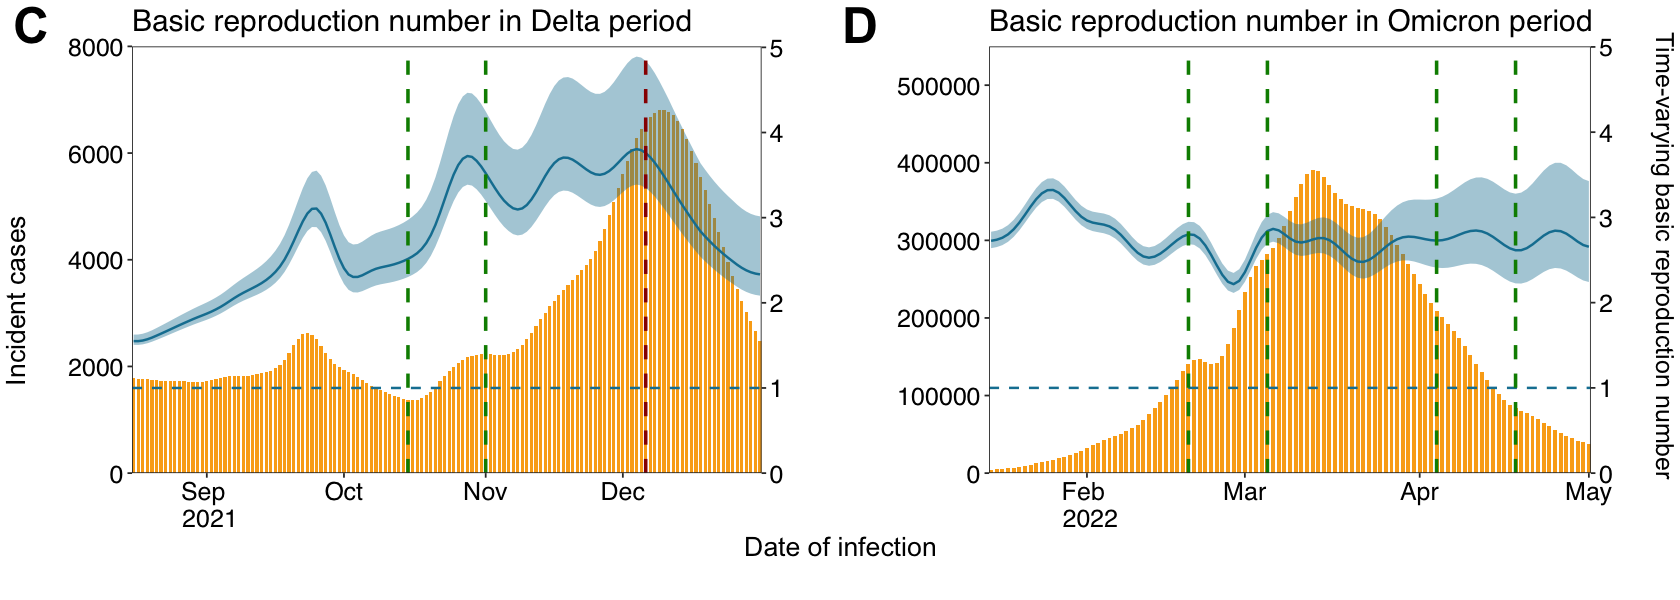

In [60]:
readRDS("RDS/R0t_Delta.rds") -> result_Delta_MA
readRDS("RDS/R0t_Omicron.rds") -> result_Omicron_MA

options(repr.plot.width=7,repr.plot.height=5)

scaling_parameter3=max(result_Delta_MA$total)/max(result_Delta_MA$MA_upper[!is.na(result_Delta_MA$MA_upper)])
options(warn=-1)

adj3=1.147

result_Delta_MA %>% filter(onset >= as.Date("2021-08-16")) %>%
    ggplot() + 
    geom_bar(aes(x=onset, y=total), fill="#FAAB18" ,stat='identity', width=0.7) +
    geom_line(aes(x=onset,y=MA_Rt*scaling_parameter3*adj3),color="#1380A1",size=0.7) +
    geom_ribbon(aes(ymax=MA_upper*scaling_parameter3*adj3, ymin=MA_lower*scaling_parameter3*adj3, x=onset), 
                fill="#1380A1", alpha = 0.4) +
    ggtitle("Basic reproduction number in Delta period") +
    labs(x="\n Date of infection", y="Incidence \n") +
    labs(x="", y="") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 15),
          plot.title = element_text(size=18, family="sans",color="black")) +
    scale_x_date(date_breaks = "1 months", expand = c(0, 0),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    scale_y_continuous(expand = c(0, 0),
                       sec.axis = sec_axis(~./(scaling_parameter3*adj3), breaks=c(0,1,2,3,4,5), 
                                           name = "")) +
    coord_cartesian(ylim = c(0,8000)) +
    geom_hline(yintercept=1*scaling_parameter3*adj3, linetype="dashed", color = "#1380A1", size =0.7) +
    geom_vline(xintercept=NPI_1, linetype="dashed", color="#990000", size=1) +
    geom_vline(xintercept=as.Date("2021-10-15"), linetype="dashed", color="green4", size=1) +
    geom_vline(xintercept=NPI_0, linetype="dashed", color="green4", size=1)  -> fig_main1


scaling_parameter4=max(result_Omicron_MA$total)/max(result_Omicron_MA$MA_upper[!is.na(result_Omicron_MA$MA_upper)])
options(warn=-1)

adj4=1.233
result_Omicron_MA %>% filter(onset >= as.Date("2022-01-15") & onset <= as.Date("2022-05-01")) %>%
    ggplot() + 
    geom_bar(aes(x=onset, y=total), fill="#FAAB18" ,stat='identity', width=0.7) +
    geom_line(aes(x=onset,y=MA_Rt*scaling_parameter4*adj4),color="#1380A1",size=0.7) +
    geom_ribbon(aes(ymax=MA_upper*scaling_parameter4*adj4, ymin=MA_lower*scaling_parameter4*adj4, x=onset), 
                fill="#1380A1", alpha = 0.4) +
    ggtitle("Basic reproduction number in Omicron period") +
    labs(x="\n Date of infection", y="Incidence \n") +
    labs(x="", y="") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 15),
          plot.title = element_text(size=18, family="sans",color="black")) +
    scale_x_date(date_breaks = "1 months", expand = c(0, 0),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    scale_y_continuous(expand = c(0, 0),
                       sec.axis = sec_axis(~./(scaling_parameter4*adj4), breaks=c(0,1,2,3,4,5), 
                                           name = "")) +
    coord_cartesian(ylim = c(0,550000)) +
    geom_hline(yintercept=1*scaling_parameter4*adj4, linetype="dashed", color = "#1380A1", size =0.7) +
    geom_vline(xintercept=NPI_2, linetype="dashed", color="green4", size=1) +
    geom_vline(xintercept=NPI_3, linetype="dashed", color="green4", size=1) +
    geom_vline(xintercept=NPI_4, linetype="dashed", color="green4", size=1) +
    geom_vline(xintercept=NPI_5, linetype="dashed", color="green4", size=1) -> fig_main2

ggarrange(fig_main1, ggplot() + theme_void(), fig_main2, nrow = 1,widths = c(1, 0.05, 1), 
          labels = c("C", "", "D"), font.label = list(size = 30), vjust=1.2, hjust=0.5) -> Fig_Rt_combined2
                 
options(repr.plot.width=14,repr.plot.height=5)
annotate_figure(Fig_Rt_combined2, 
                left=text_grob("Incident cases", size=16, rot=90),
                right=text_grob("Time-varying basic reproduction number", size=15, rot=270, hjust=0.6),
                bottom=text_grob("Date of infection", vjust= -1.5, size=16)) -> Fig_Rt_combined2

Fig_Rt_combined2

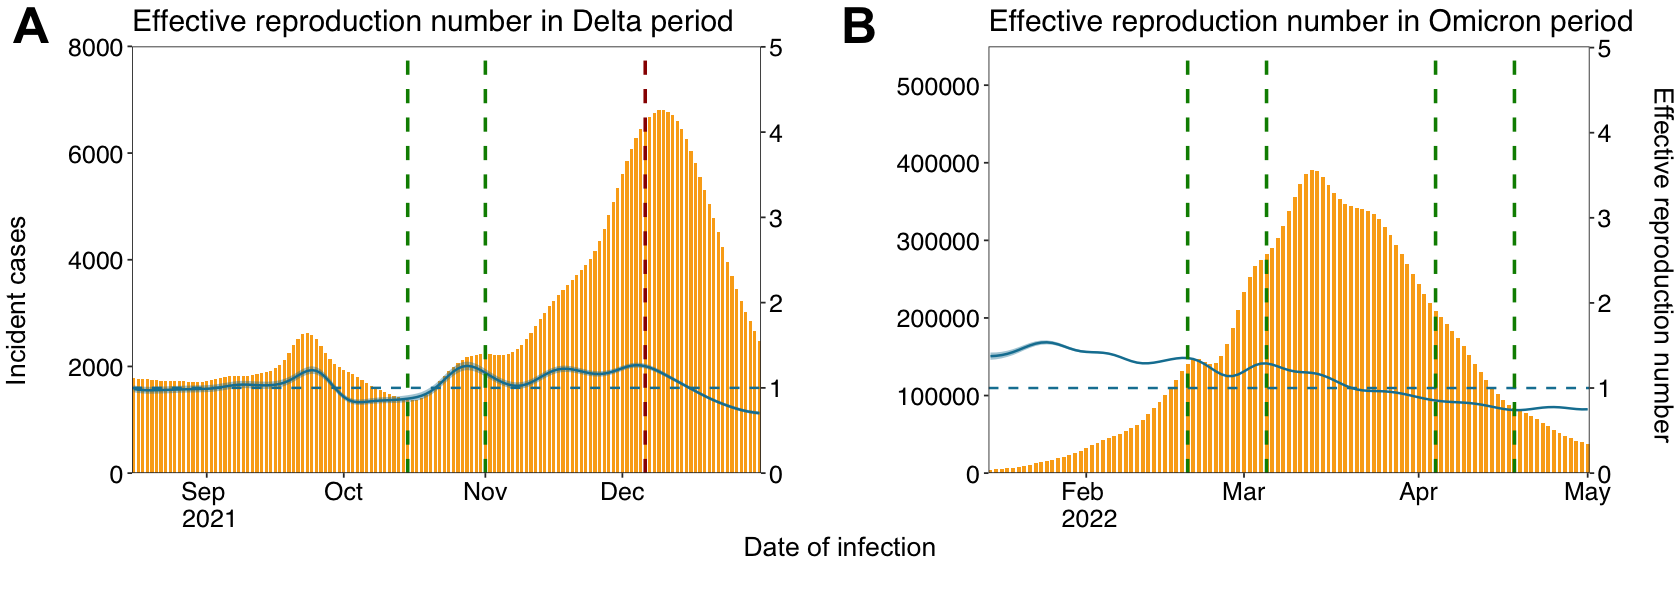

In [63]:
readRDS("result_non_Omi_smooth.rds") -> result_non_Omi
readRDS("result_Omi_smooth.rds") -> result_Omi

adj1=0.331
scaling_parameter1=max(result_non_Omi$total)/max(result_non_Omi$upper[!is.na(result_non_Omi$upper)])

result_non_Omi %>% rename(date=onset) %>% filter(date >= as.Date("2021-08-16") & date <= as.Date("2022-12-31")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=total), fill="#FAAB18" ,stat='identity', width=0.7) +
    geom_line(aes(x=date,y=MA_Rt*scaling_parameter1*adj1),color="#1380A1",size=0.7) +
    geom_ribbon(aes(ymax=MA_upper*scaling_parameter1*adj1, ymin=MA_lower*scaling_parameter1*adj1, x=date), 
                fill="#1380A1", alpha = 0.4) +
    ggtitle("Effective reproduction number in Delta period") +
    labs(x="\n Date of infection", y="Incidence \n") +
    labs(x="", y="") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 15),
          plot.title = element_text(size=18, family="sans",color="black")) +
    scale_x_date(date_breaks = "1 months", expand = c(0, 0),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    scale_y_continuous(expand = c(0, 0),
                       sec.axis = sec_axis(~./(scaling_parameter1*adj1), breaks=c(0,1,2,3,4,5),  
                                           name = "")) +
    coord_cartesian(ylim = c(0,8000)) +
    geom_hline(yintercept=1*scaling_parameter1*adj1, linetype="dashed", color = "#1380A1", size =0.7) +
    geom_vline(xintercept=NPI_1, linetype="dashed", color="#990000", size=1) +
    geom_vline(xintercept=as.Date("2021-10-15"), linetype="dashed", color="green4", size=1) +
    geom_vline(xintercept=NPI_0, linetype="dashed", color="green4", size=1) -> fig_org_delta

                 

adj2=0.466
scaling_parameter2=max(result_Omi$total)/max(result_Omi$upper[!is.na(result_Omi$upper)])

result_Omi %>% rename(date=onset) %>% filter(date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=total), fill="#FAAB18" ,stat='identity', width=0.7) +
    geom_line(aes(x=date,y=MA_Rt*scaling_parameter2*adj2),color="#1380A1",size=0.7) +
    geom_ribbon(aes(ymax=MA_upper*scaling_parameter2*adj2, ymin=MA_lower*scaling_parameter2*adj2, x=date), 
                fill="#1380A1", alpha = 0.4) +
    ggtitle("Effective reproduction number in Omicron period") +
    labs(x="\n Date of infection", y="Incidence \n") +
    labs(x="", y="") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 15),
          plot.title = element_text(size=18, family="sans",color="black")) +
    scale_x_date(date_breaks = "1 months", expand = c(0, 0),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    scale_y_continuous(expand = c(0, 0),
                       sec.axis = sec_axis(~./(scaling_parameter2*adj2), breaks=c(0,1,2,3,4,5), 
                                           name = "")) +
    coord_cartesian(ylim = c(0,550000)) +
    geom_hline(yintercept=1*scaling_parameter2*adj2, linetype="dashed", color = "#1380A1", size =0.7) +
    geom_vline(xintercept=NPI_2, linetype="dashed", color="green4", size=1) +
    geom_vline(xintercept=NPI_3, linetype="dashed", color="green4", size=1) +
    geom_vline(xintercept=NPI_4, linetype="dashed", color="green4", size=1) +
    geom_vline(xintercept=NPI_5, linetype="dashed", color="green4", size=1) -> fig_org_omicron                 
                 
                 
options(repr.plot.width=14,repr.plot.height=5)
ggarrange(fig_org_delta, ggplot() + theme_void(), fig_org_omicron, nrow = 1,widths = c(1, 0.05, 1), 
          labels = c("A", "", "B"), font.label = list(size = 30), vjust=1.2, hjust=0.5) -> Fig_Rt_combined

options(repr.plot.width=14,repr.plot.height=5)
annotate_figure(Fig_Rt_combined, 
                left=text_grob("Incident cases", size=16, rot=90),
                right=text_grob("Effective reproduction number", size=16, rot=270, hjust=0.6),
                bottom=text_grob("Date of infection", vjust= -1.5, size=16)) -> Fig_Rt_combined
                 
Fig_Rt_combined

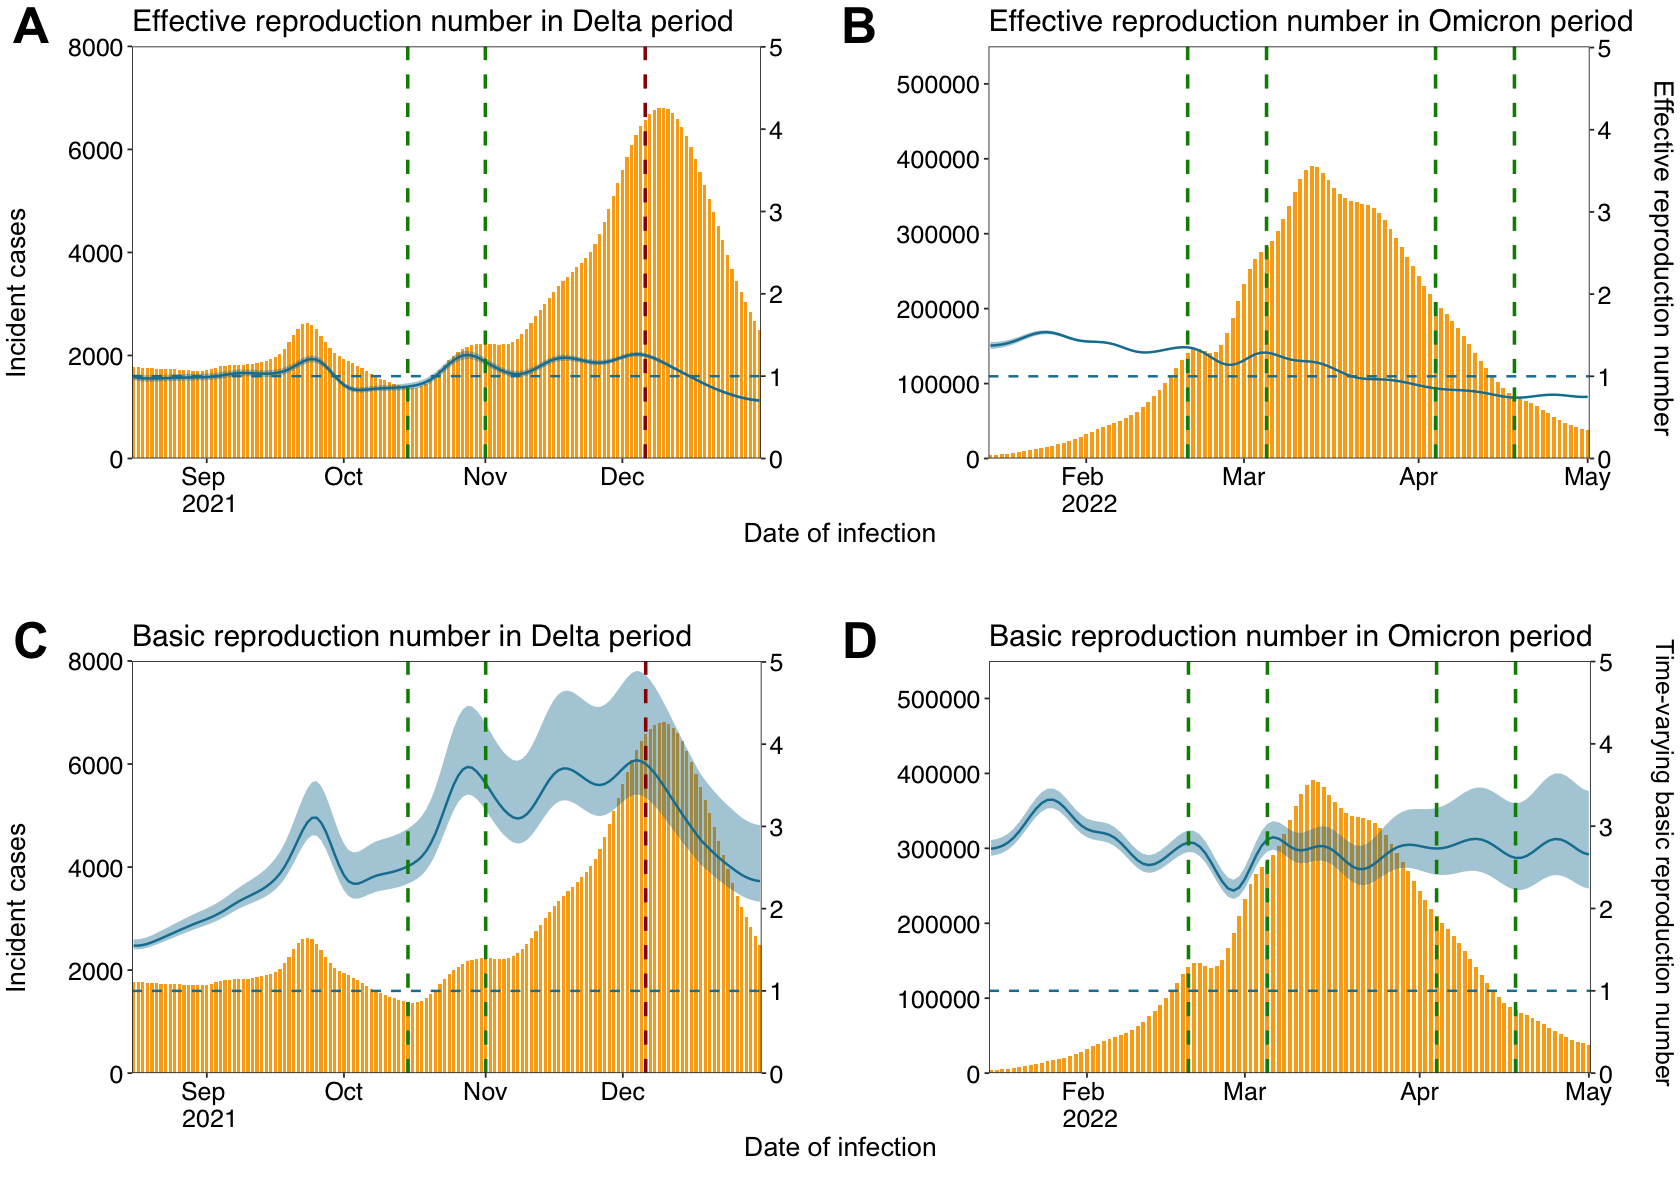

In [64]:
options(repr.plot.width=14,repr.plot.height=10)
ggarrange(Fig_Rt_combined, ggplot() + theme_void(), Fig_Rt_combined2, 
          ncol = 1, heights = c(1, 0.05, 1)) -> Fig_Rt_combined_all

Fig_Rt_combined_all

ggsave("../figures/Final figures/Fig_2.png", width = 14, height = 10, dpi=300, bg="white")